# Self-Stacking GroupCV XGBoost

In this notebook, I introduce a self-stacking XGBoost (XGB) pipeline. 

XGB model does not support multi-label learning so it cannot fully learn the label correlation as well as neural networks (NNs). Then I come up with an idea of self-stacking learning for XGB. The purpose is to enhance the label correlation learning by taking the first-stage predictions as additional features for the second-stage learning.

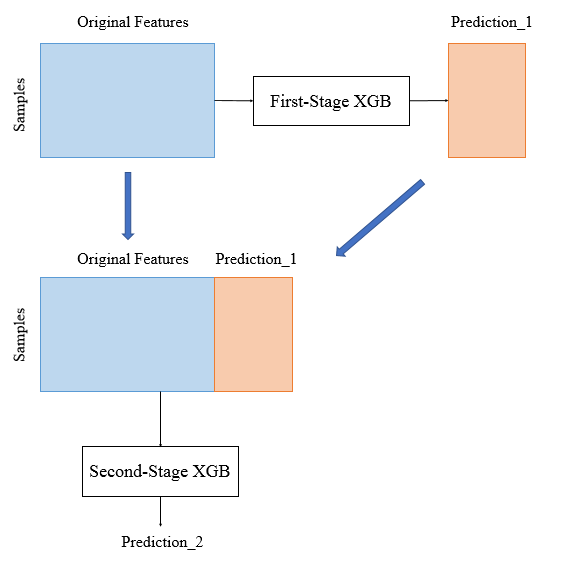

## 参考

- XGBoostでself-stacking  
第1段階の予測値を第2段階の学習の追加特徴量とし、クラス間の関係性を学習させるのが目的  
https://www.kaggle.com/gogo827jz/self-stacking-groupcv-xgboost

<br>

- ポジティブサンプル(=1)を多く含むターゲットを最初に学習させる
oofを保存し、oofの予測値を特徴量として追加することで、ポジティブなサンプル数が少ない学習対象の特徴量を得る  
https://www.kaggle.com/underwearfitting/partial-self-stacking-lightgbm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import pickle
import joblib
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
from time import time

In [ ]:
import os
import random as rn
import numpy as np


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)

    rn.seed(seed)
    np.random.seed(seed)

In [ ]:
from sklearn.metrics import log_loss


def score(Y, Y_pred):
    _, n_classes = Y.shape

    losses = []

    for j in range(n_classes):
        loss = log_loss(Y.iloc[:, j], Y_pred.iloc[:, j], labels=[0, 1])

        losses.append(loss)

    return np.mean(losses)

In [ ]:
from sklearn.metrics import roc_auc_score


def auc_score(Y, Y_pred):
    _, n_classes = Y.shape

    aucs = []

    for j in range(n_classes):
        auc = roc_auc_score(Y.iloc[:, j], Y_pred.iloc[:, j])

        aucs.append(auc)

    return np.mean(aucs)

In [ ]:
def compute_row_statistics(X, prefix=""):
    Xt = pd.DataFrame()

    for agg_func in [
        # "min",
        # "max",
        "mean",
        "std",
        "kurtosis",
        "skew",
    ]:
        Xt[f"{prefix}{agg_func}"] = X.agg(agg_func, axis=1)

    return Xt

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


class ClippedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, high=0.99, low=0.01):
        self.copy = copy
        self.high = high
        self.low = low

    def fit(self, X, y=None):
        self.data_max_ = X.quantile(q=self.high)
        self.data_min_ = X.quantile(q=self.low)

        return self

    def transform(self, X):
        if self.copy:
            X = X.copy()

        X.clip(self.data_min_, self.data_max_, axis=1, inplace=True)

        return X

# CV

In [ ]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection._split import _BaseKFold


class MultilabelStratifiedGroupKFold(_BaseKFold):
    def __init__(self, n_splits=5, random_state=None, shuffle=False):
        super().__init__(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    def _iter_test_indices(self, X=None, y=None, groups=None):
        cv = MultilabelStratifiedKFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=self.shuffle,
        )

        value_counts = groups.value_counts()
        regluar_indices = value_counts.loc[
            (value_counts == 6) | (value_counts == 12) | (value_counts == 18)
        ].index.sort_values()
        irregluar_indices = value_counts.loc[
            (value_counts != 6) & (value_counts != 12) & (value_counts != 18)
        ].index.sort_values()

        group_to_fold = {}
        tmp = y.groupby(groups).mean().loc[regluar_indices]

        for fold, (_, test) in enumerate(cv.split(tmp, tmp)):
            group_to_fold.update({group: fold for group in tmp.index[test]})

        sample_to_fold = {}
        tmp = y.loc[groups.isin(irregluar_indices)]

        for fold, (_, test) in enumerate(cv.split(tmp, tmp)):
            sample_to_fold.update({sample: fold for sample in tmp.index[test]})

        folds = groups.map(group_to_fold)
        is_na = folds.isna()
        folds[is_na] = folds[is_na].index.map(sample_to_fold).values

        for i in range(self.n_splits):
            yield np.where(folds == i)[0]

# Data Preparation

In [ ]:
dtype = {"cp_type": "category", "cp_dose": "category"}
index_col = "sig_id"

train_features = pd.read_csv(
    "../input/lish-moa/train_features.csv", dtype=dtype, index_col=index_col
)
X = train_features.select_dtypes("number")
Y_nonscored = pd.read_csv(
    "../input/lish-moa/train_targets_nonscored.csv", index_col=index_col
)
Y = pd.read_csv("../input/lish-moa/train_targets_scored.csv", index_col=index_col)
groups = pd.read_csv(
    "../input/lish-moa/train_drug.csv", index_col=index_col, squeeze=True
)

test_features = pd.read_csv(
    "../input/lish-moa/test_features.csv", dtype=dtype, index_col=index_col
)
X_test = test_features.select_dtypes("number")

columns = Y.columns

In [ ]:
c_prefix = "c-"
g_prefix = "g-"
c_columns = X.columns.str.startswith(c_prefix)
g_columns = X.columns.str.startswith(g_prefix)
X_c = compute_row_statistics(X.loc[:, c_columns], prefix=c_prefix)
X_g = compute_row_statistics(X.loc[:, g_columns], prefix=g_prefix)

clipped_features = ClippedFeatures()
X = clipped_features.fit_transform(X)
with open("clipped_features.pkl", "wb") as f:
    pickle.dump(clipped_features, f)

X = pd.concat([X, X_c, X_g], axis=1)

# params

In [ ]:
n_seeds = 5
n_splits = 5
LBS = 0.0008

param = {'objective': 'binary:logistic',
         'eval_metric': 'logloss', 
         #'tree_method': 'gpu_hist', 
         'verbosity': 0, 
         'colsample_bytree': 0.1818593017814899, 
         'eta': 0.012887963193108452, 
         'gamma': 6.576022976359221, 
         'max_depth': 8, 
         'min_child_weight': 8.876744371188476, 
         'subsample': 0.7813380253086911, 
        }
n_estimators = 1000
early_stopping_rounds = 25

# pick top features that have more postive samples
top_k = 75

# Stage 2: Training 'hard' targets, less postive samples
is_hard = True


#DEBUG = True
DEBUG = False
if DEBUG:
    n_seeds = 2
    n_splits = 2
    
    n_estimators = 5
    early_stopping_rounds = 2
    
    columns = [
        "atp-sensitive_potassium_channel_antagonist",  # 陽性ラベル1個だけ
        "erbb2_inhibitor",  # 陽性ラベル1個だけ
        "antiarrhythmic",  # 陽性ラベル6個だけ
#        "aldehyde_dehydrogenase_inhibitor",  # 陽性ラベル7個だけ
#        "lipase_inhibitor",  # 陽性ラベル12個だけ
#        "sphingosine_receptor_agonist",  # 陽性ラベル25個だけ
#        "igf-1_inhibitor",  # 陽性ラベル37個だけ
#        "potassium_channel_activator",  # 陽性ラベル55個だけ
#        "potassium_channel_antagonist",  # 陽性ラベル98個だけ
#        "dopamine_receptor_agonist",  # 陽性ラベル121個だけ
#        "nfkb_inhibitor",  # 陽性ラベル832個
#        "cyclooxygenase_inhibitor",  # 陽性ラベル435個
#        "dna_inhibitor",  # 陽性ラベル402個
#        "glutamate_receptor_antagonist",  # 陽性ラベル367個
#        "tubulin_inhibitor",  # 陽性ラベル316個
#        "pdgfr_inhibitor",  # 陽性ラベル297個
#        "calcium_channel_blocker",  # 陽性ラベル281個
        "flt3_inhibitor",  # 陽性ラベル279個
        "progesterone_receptor_agonist",  # 陽性ラベル119個
        "hdac_inhibitor",  # 陽性ラベル106個
    ]
    Y = Y[columns]
    
    top_k = Y.shape[1] // 2

    print(f"DEBUG: {DEBUG}")

In [ ]:
train_size, n_features = X.shape
_, n_classes = Y.shape
print("n_classes:", n_classes)

# XGB Setup

In [ ]:
def run_xgb(y, outdir):
    
    os.makedirs(outdir, exist_ok=True)
    
    y_pred = np.zeros((train_size, y.shape[1]))
    y_pred = pd.DataFrame(y_pred, columns=y.columns, index=y.index)

    for i in tqdm(range(n_seeds)):
        set_seed(seed=i)

        cv = MultilabelStratifiedGroupKFold(n_splits=n_splits, random_state=i, shuffle=True)
        cv_split = cv.split(X, y, groups)

        for j, (trn_idx, val_idx) in enumerate(cv_split):
            print(f"------------ fold:{j} ------------")

            X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
            y_train_targets, y_val_targets = y.iloc[trn_idx], y.iloc[val_idx]

            # Label Smoothing
            y_train_targets = y_train_targets * (1 - LBS) + 0.5 * LBS
            
            for tar, tar_col in enumerate(y.columns):
                y_train, y_val = y_train_targets.values[:, tar], y_val_targets.values[:, tar]

                xgb_tr  = xgb.DMatrix(X_train, label=y_train, nthread=-1)
                xgb_val = xgb.DMatrix(X_val, label=y_val, nthread=-1)
                
                model = xgb.train(
                    param, 
                    xgb_tr, 
                    n_estimators, 
                    [(xgb_val, 'eval')],
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=0,
                )

                y_pred[tar_col][val_idx] += (
                    model.predict(xgb_val, ntree_limit=model.best_ntree_limit) / n_seeds
                )

                joblib.dump(
                    model, f"{outdir}/model_seed_{i}_fold_{j}_{y.columns[tar]}.jlb", compress=True
                )

    y_pred[train_features["cp_type"] == "ctl_vehicle"] = 0.0
    
    return y_pred

In [ ]:
easy_tar = Y.sum(axis=0).sort_values(ascending=False)[:top_k].index.values
hard_tar = Y.sum(axis=0).sort_values(ascending=False)[top_k:].index.values
assert len(easy_tar) + len(hard_tar) == n_classes

print("len(easy_tar):", len(easy_tar))
print("len(hard_tar):", len(hard_tar))

# Stage 1: Training 'Easy' Target, more positive samples

In [ ]:
%%time
Y_pred_easy = run_xgb(Y[easy_tar], outdir="first")
display(Y_pred_easy.head())

# Stage 2(Self-Stacking): 
- Training 'hard' targets, less postive samples

or

- Training all targets

In [ ]:
#update train and test for stage 2, append the oofs as features
X = pd.concat([X, Y_pred_easy[easy_tar]], axis=1)
display(X.head())

In [ ]:
%%time

if is_hard:
    Y_pred_hard = run_xgb(Y[hard_tar], outdir="second")
    Y_pred = Y_pred_hard.join(Y_pred_easy)
    Y_pred = Y_pred[columns]

else:
    Y_pred = run_xgb(Y[columns], outdir="second")
    Y_pred = Y_pred[columns]

with open(f"Y_pred.pkl", "wb") as f:
    pickle.dump(Y_pred, f)
    
print(Y_pred.shape)
display(Y_pred)

# oof

In [ ]:
oof_logloss = score(Y[columns], Y_pred[columns])
oof_auc = auc_score(Y[columns], Y_pred[columns])
print(f"oof_logloss:", oof_logloss)
print(f"oof_auc:", oof_auc)

# predict test

In [ ]:
%%time

test_features = pd.read_csv(
    "../input/lish-moa/test_features.csv", dtype=dtype, index_col=index_col
)
X_test = test_features.select_dtypes("number")
X_c = compute_row_statistics(X_test.loc[:, c_columns], prefix=c_prefix)
X_g = compute_row_statistics(X_test.loc[:, g_columns], prefix=g_prefix)

with open("./clipped_features.pkl", "rb") as f:
    clipped_features = pickle.load(f)
X_test = clipped_features.transform(X_test)

X_test = pd.concat([X_test, X_c, X_g], axis=1)
print(f"X_test.shape: {X_test.shape}")


xgb_tt = xgb.DMatrix(X_test, nthread=-1)

Y_test_pred = np.zeros((X_test.shape[0], len(columns)))
Y_test_pred = pd.DataFrame(Y_test_pred, columns=columns, index=test_features.index)

for i in range(n_seeds):
    for j in range(n_splits):
        for tar, tar_col in enumerate(easy_tar):

            m_path = f"first/model_seed_{i}_fold_{j}_{tar_col}.jlb"

            if os.path.exists(m_path):
                print(m_path)
                model = joblib.load(m_path)
                Y_test_pred.loc[:, tar_col] += model.predict(xgb_tt, ntree_limit=model.best_ntree_limit) / (n_seeds * n_splits)
            else:
                Y_test_pred.loc[:, tar_col] += np.array([Y_pred.iloc[:,tar].mean()] * X_test.shape[0]) / (n_seeds * n_splits)

X_test = pd.concat([X_test, Y_test_pred[easy_tar]], axis=1)
xgb_tt = xgb.DMatrix(X_test, nthread=-1)
print(f"X_test.shape: {X_test.shape}")

if is_hard == False:
    hard_tar = columns

for i in range(n_seeds):
    for j in range(n_splits):
        for tar, tar_col in enumerate(hard_tar):

            m_path = f"second/model_seed_{i}_fold_{j}_{tar_col}.jlb"

            if os.path.exists(m_path):
                print(m_path)
                model = joblib.load(m_path)
                Y_test_pred.loc[:, tar_col] += model.predict(xgb_tt, ntree_limit=model.best_ntree_limit) / (n_seeds * n_splits)
            else:
                Y_test_pred.loc[:, tar_col] += np.array([Y_pred.iloc[:,tar].mean()] * X_test.shape[0]) / (n_seeds * n_splits)


Y_test_pred[test_features["cp_type"] == "ctl_vehicle"] = 0.0

Y_test_pred.to_csv("submission.csv")

In [ ]:
print(Y_test_pred.shape)
display(Y_test_pred)